In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import os

In [ ]:

zip_file_path = '/content/drive/My Drive/BTP_Project.zip'
extract_path = '/content/drive/My Drive/BTP_Project'

import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [23]:
os.listdir(extract_path)

['data']

In [24]:
data_path = os.path.join(extract_path, 'data')
os.listdir(data_path)

['test', 'train', 'validation']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(data_path, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 58535 images belonging to 9 classes.
Found 18012 images belonging to 9 classes.
Found 13496 images belonging to 9 classes.


In [26]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


optimizer = Adam(learning_rate=0.0001)


lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,  # Wait for 3 epochs before reducing learning rate
    factor=0.5,  # Reduce LR by a factor of 0.5
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)


model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
# Unfreeze the top layers of the VGG19 base model (fine-tuning)
for layer in base_model.layers[-4:]:  # Unfreeze last 4 layers
    layer.trainable = True

# Recompile the model to apply changes
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get the class labels from the generator
class_labels = list(train_generator.class_indices.values())

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weight_dict,
    callbacks=[lr_reduction]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1456s 772ms/step - accuracy: 0.5471 - loss: 1.2420 - val_accuracy: 0.8677 - val_loss: 0.3801 - learning_rate: 1.0000e-05
Epoch 2/10
   1/1829 ━━━━━━━━━━━━━━━━━━━━ 17:47 584ms/step - accuracy: 0.7812 - loss: 0.6673

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1829/1829 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7812 - loss: 0.6673 - val_accuracy: 0.9286 - val_loss: 0.2725 - learning_rate: 1.0000e-05
Epoch 3/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1431s 749ms/step - accuracy: 0.8139 - loss: 0.5383 - val_accuracy: 0.8924 - val_loss: 0.3070 - learning_rate: 1.0000e-05
Epoch 4/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - accuracy: 0.8750 - loss: 0.4371 - val_accuracy: 0.8929 - val_loss: 0.2302 - learning_rate: 1.0000e-05
Epoch 5/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1413s 750ms/step - accuracy: 0.8495 - loss: 0.4445 - val_accuracy: 0.9092 - val_loss: 0.2540 - learning_rate: 1.0000e-05
Epoch 6/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1s 89us/step - accuracy: 0.8438 - loss: 0.4391 - val_accuracy: 1.0000 - val_loss: 0.0657 - learning_rate: 1.0000e-05
Epoch 7/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1393s 745ms/step - accuracy: 0.8669 - loss: 0.3988 - val_accuracy: 0.9219 - val_loss: 0.2202 - learning_rate: 1.0000e-05
Epoch 8/10
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1s

In [31]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')

422/422 ━━━━━━━━━━━━━━━━━━━━ 84s 199ms/step - accuracy: 0.9258 - loss: 0.2186
Test accuracy: 0.9226437211036682


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

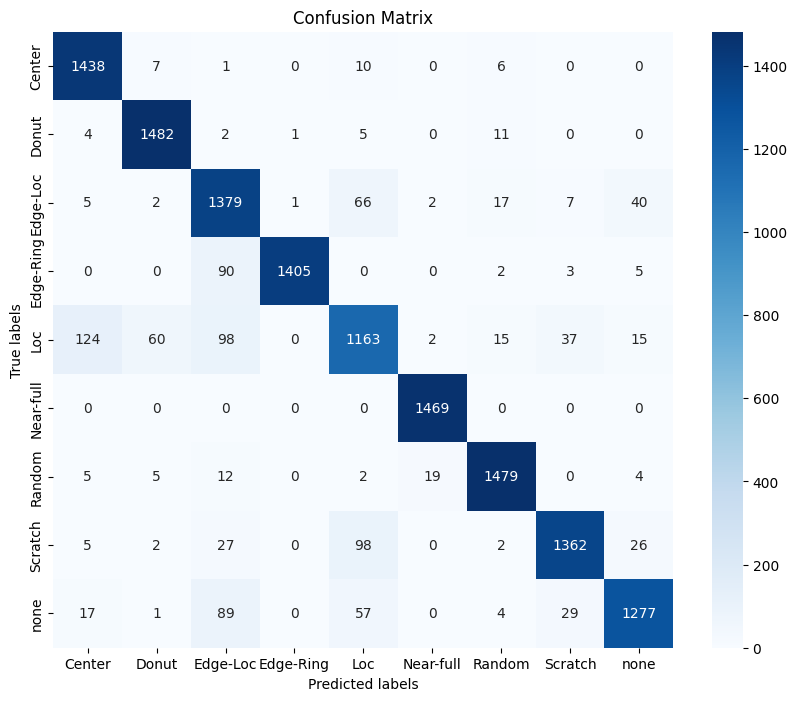

Classification Report:
               precision    recall  f1-score   support

      Center       0.90      0.98      0.94      1462
       Donut       0.95      0.98      0.97      1505
    Edge-Loc       0.81      0.91      0.86      1519
   Edge-Ring       1.00      0.93      0.96      1505
         Loc       0.83      0.77      0.80      1514
   Near-full       0.98      1.00      0.99      1469
      Random       0.96      0.97      0.97      1526
     Scratch       0.95      0.89      0.92      1522
        none       0.93      0.87      0.90      1474

    accuracy                           0.92     13496
   macro avg       0.92      0.92      0.92     13496
weighted avg       0.92      0.92      0.92     13496

F1 Score (weighted): 0.9225039387393562
Precision (weighted): 0.9242604059632614
Recall (weighted): 0.9227919383521044


In [35]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get true labels and predictions for the test set
true_labels = []
predicted_labels = []

# Iterate through the test generator to collect all predictions
for inputs, labels in test_generator:
    # Append the true labels to the list (convert from one-hot encoding to class indices if needed)
    true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot to class indices

    # Predict the class labels for the batch
    predictions = model.predict(inputs, batch_size=test_generator.batch_size)

    # Get the predicted class labels (argmax returns the index of the highest probability)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Convert one-hot to class indices

    # Break after one epoch if needed (you can remove this if you want to process the full test set)
    if len(true_labels) >= test_generator.samples:
        break

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Ensure that both arrays are of the same length
print(f"Length of true labels: {len(true_labels)}")
print(f"Length of predicted labels: {len(predicted_labels)}")

# Check if both arrays are of the same length
assert len(true_labels) == len(predicted_labels), "Mismatch between true and predicted labels length."

# Step 2: Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Step 3: Classification Report (Precision, Recall, F1 Score)
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)

# Step 4: F1 Score (weighted)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score (weighted): {f1}")

# Step 5: Precision and Recall (weighted)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Precision (weighted): {precision}")
print(f"Recall (weighted): {recall}")


In [ ]:

model.save('/content/drive/My Drive/BTP_Project/VGG-19.h5')